### Code written by Pranav Durai
### Fine-Tuning SegFormer for Improved Lane Detection

In [11]:


import os
import cv2
import numpy as np
import copy
from tqdm import tqdm
import requests

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor
from torchvision import transforms as TF
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import SegformerForSemanticSegmentation
from transformers import get_scheduler

from sklearn.metrics import jaccard_score

In [12]:
import kagglehub
sovitrath_road_lane_segmentation_train_test_split_path = kagglehub.dataset_download('sovitrath/road-lane-segmentation-train-test-split')

print('Data source import complete.')

Using Colab cache for faster access to the 'road-lane-segmentation-train-test-split' dataset.
Data source import complete.


In [13]:
import os

for root, dirs, files in os.walk(sovitrath_road_lane_segmentation_train_test_split_path):
    print(root)
    print(files)
    break

/kaggle/input/road-lane-segmentation-train-test-split
[]


In [14]:


!mv /root/.cache/kagglehub/datasets/sovitrath/road-lane-segmentation-train-test-split/versions/1/* /content/

mv: cannot stat '/root/.cache/kagglehub/datasets/sovitrath/road-lane-segmentation-train-test-split/versions/1/*': No such file or directory


In [15]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

mask_dirs = [
    "/content/train/masks",
    "/content/valid/masks"
]

def convert_to_binary(mask_path):
    mask = cv2.imread(mask_path)
    if mask is None:
        return None

    gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    binary = np.where(gray > 0, 255, 0).astype(np.uint8)
    return mask, binary


# Convert all masks
for dir_path in mask_dirs:
    print(f"Processing: {dir_path}")

    for file in os.listdir(dir_path):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            mask_path = os.path.join(dir_path, file)

            result = convert_to_binary(mask_path)
            if result is None:
                continue

            original, binary = result

            # OVERWRITE original RGB mask with binary mask
            cv2.imwrite(mask_path, binary)

    print(f"Done: {dir_path}\n")

Processing: /content/train/masks
Done: /content/train/masks

Processing: /content/valid/masks
Done: /content/valid/masks



Sample from TRAIN masks:


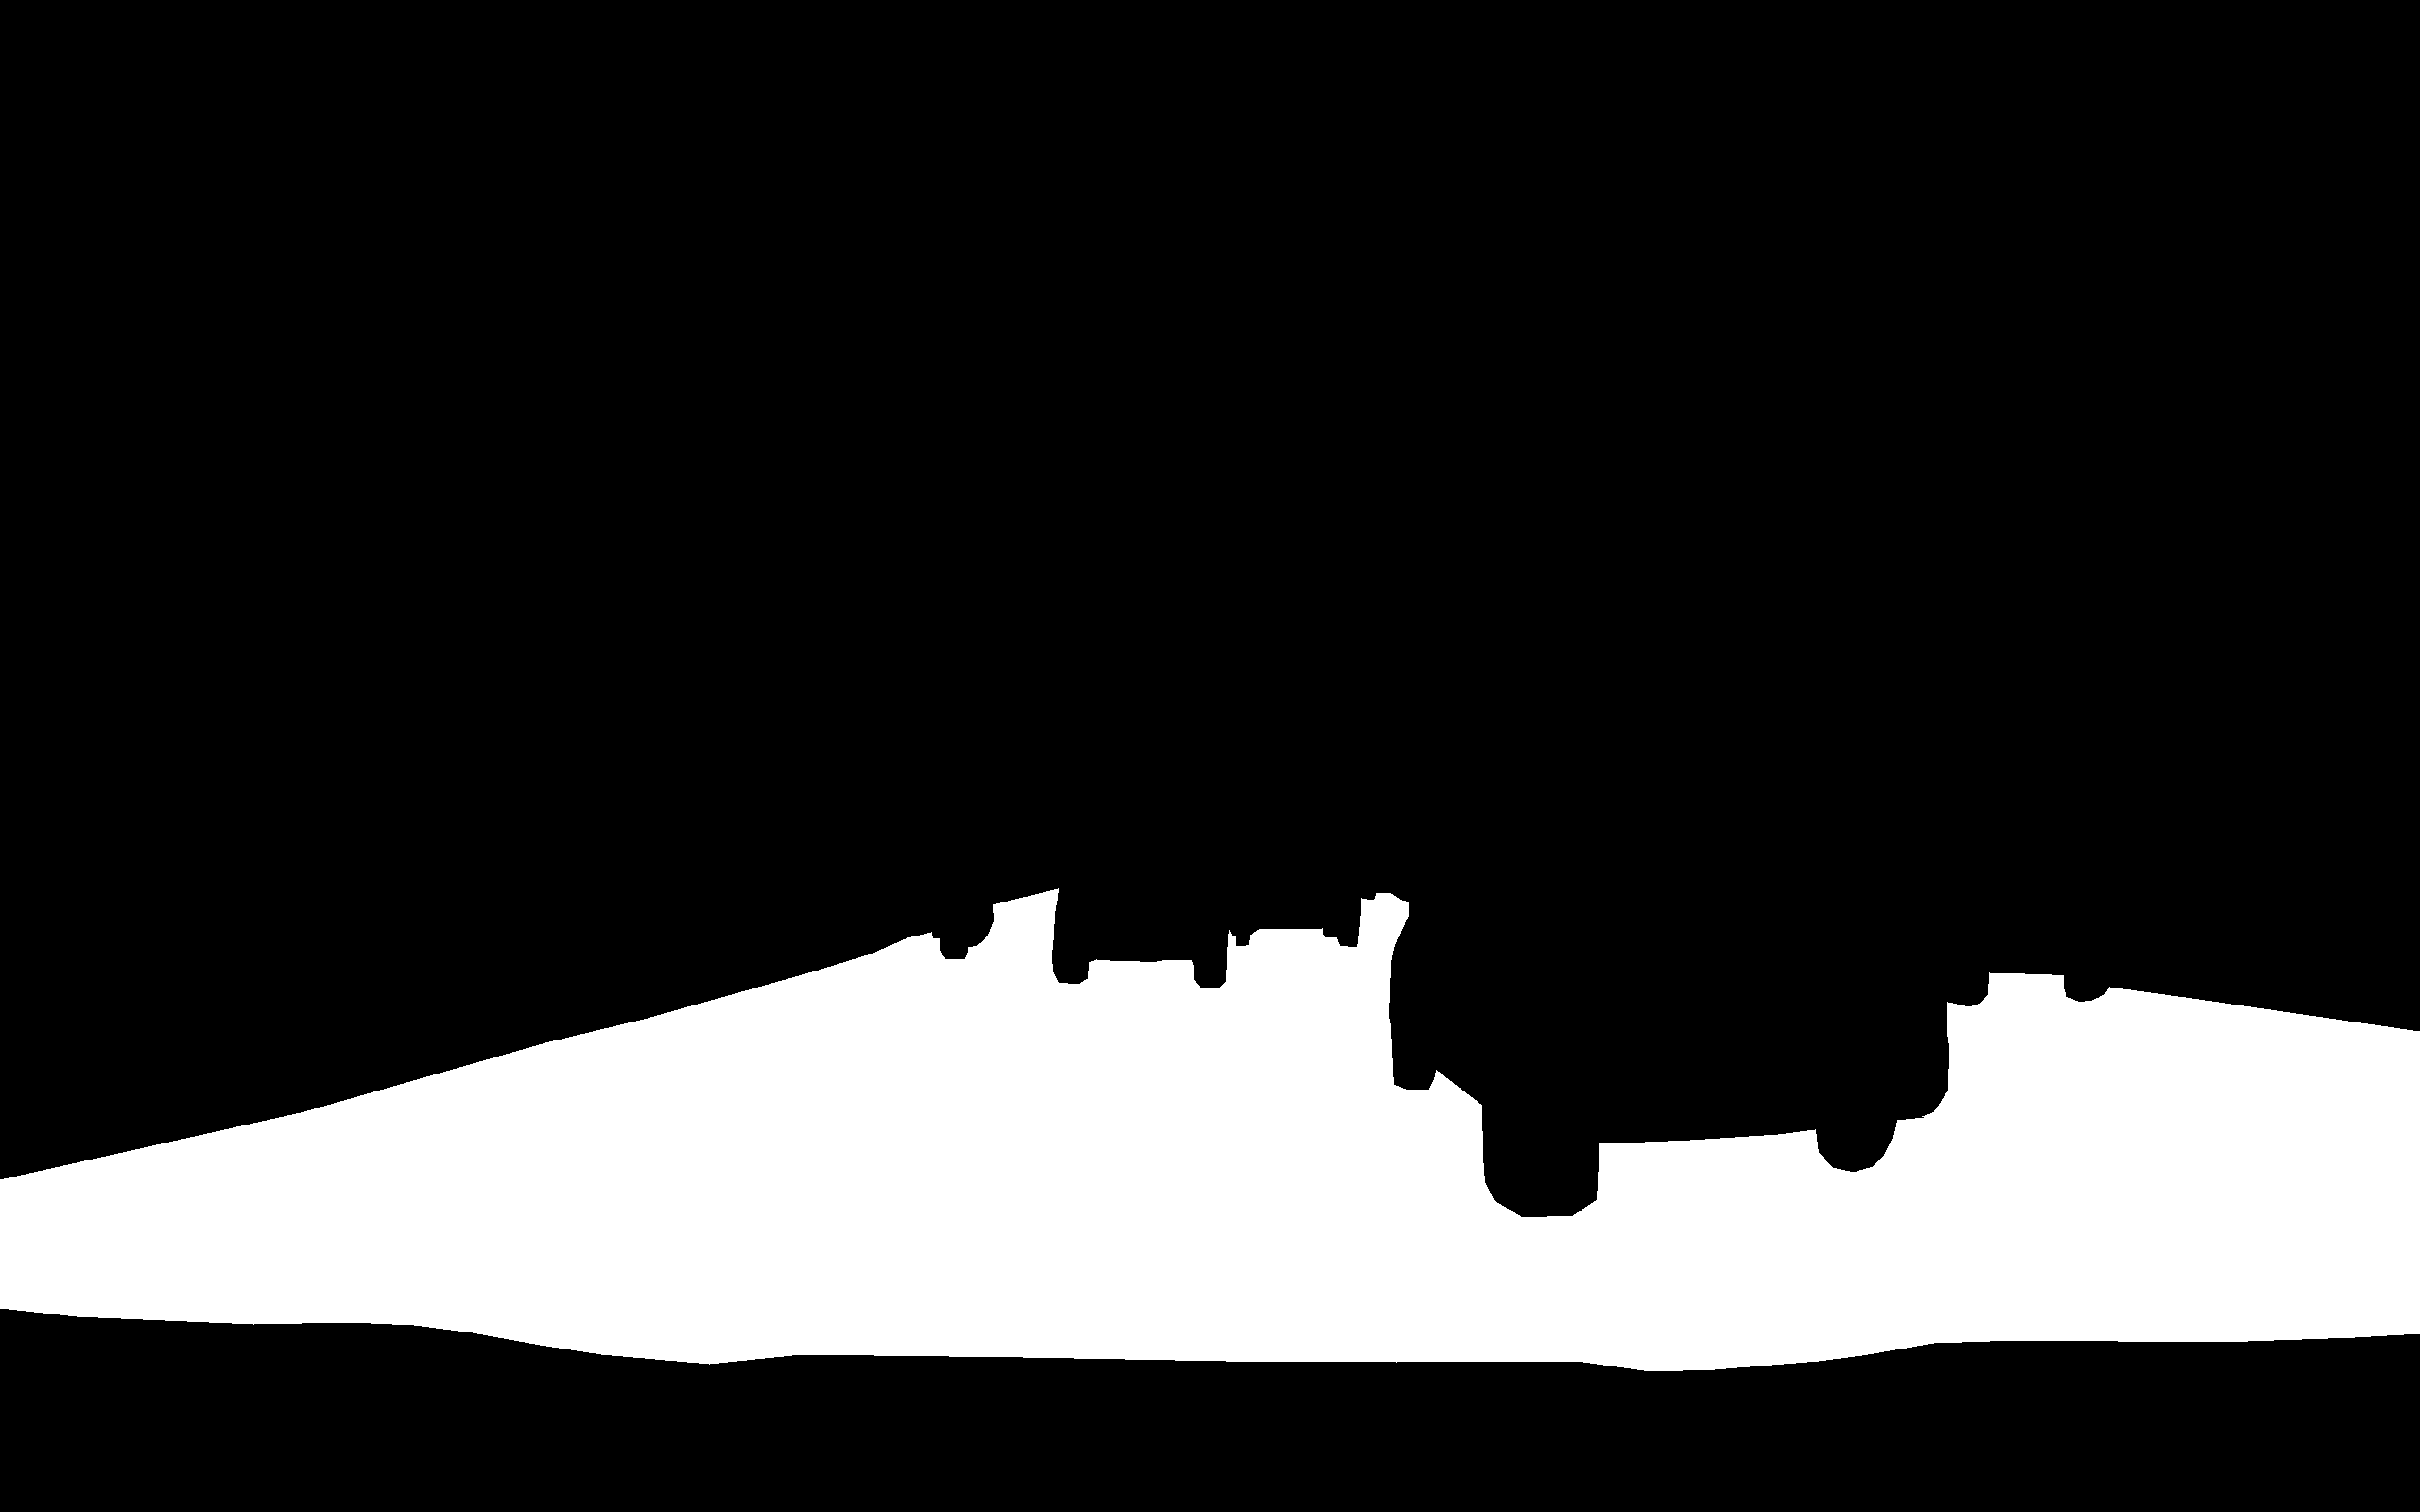


Sample from VALID masks:


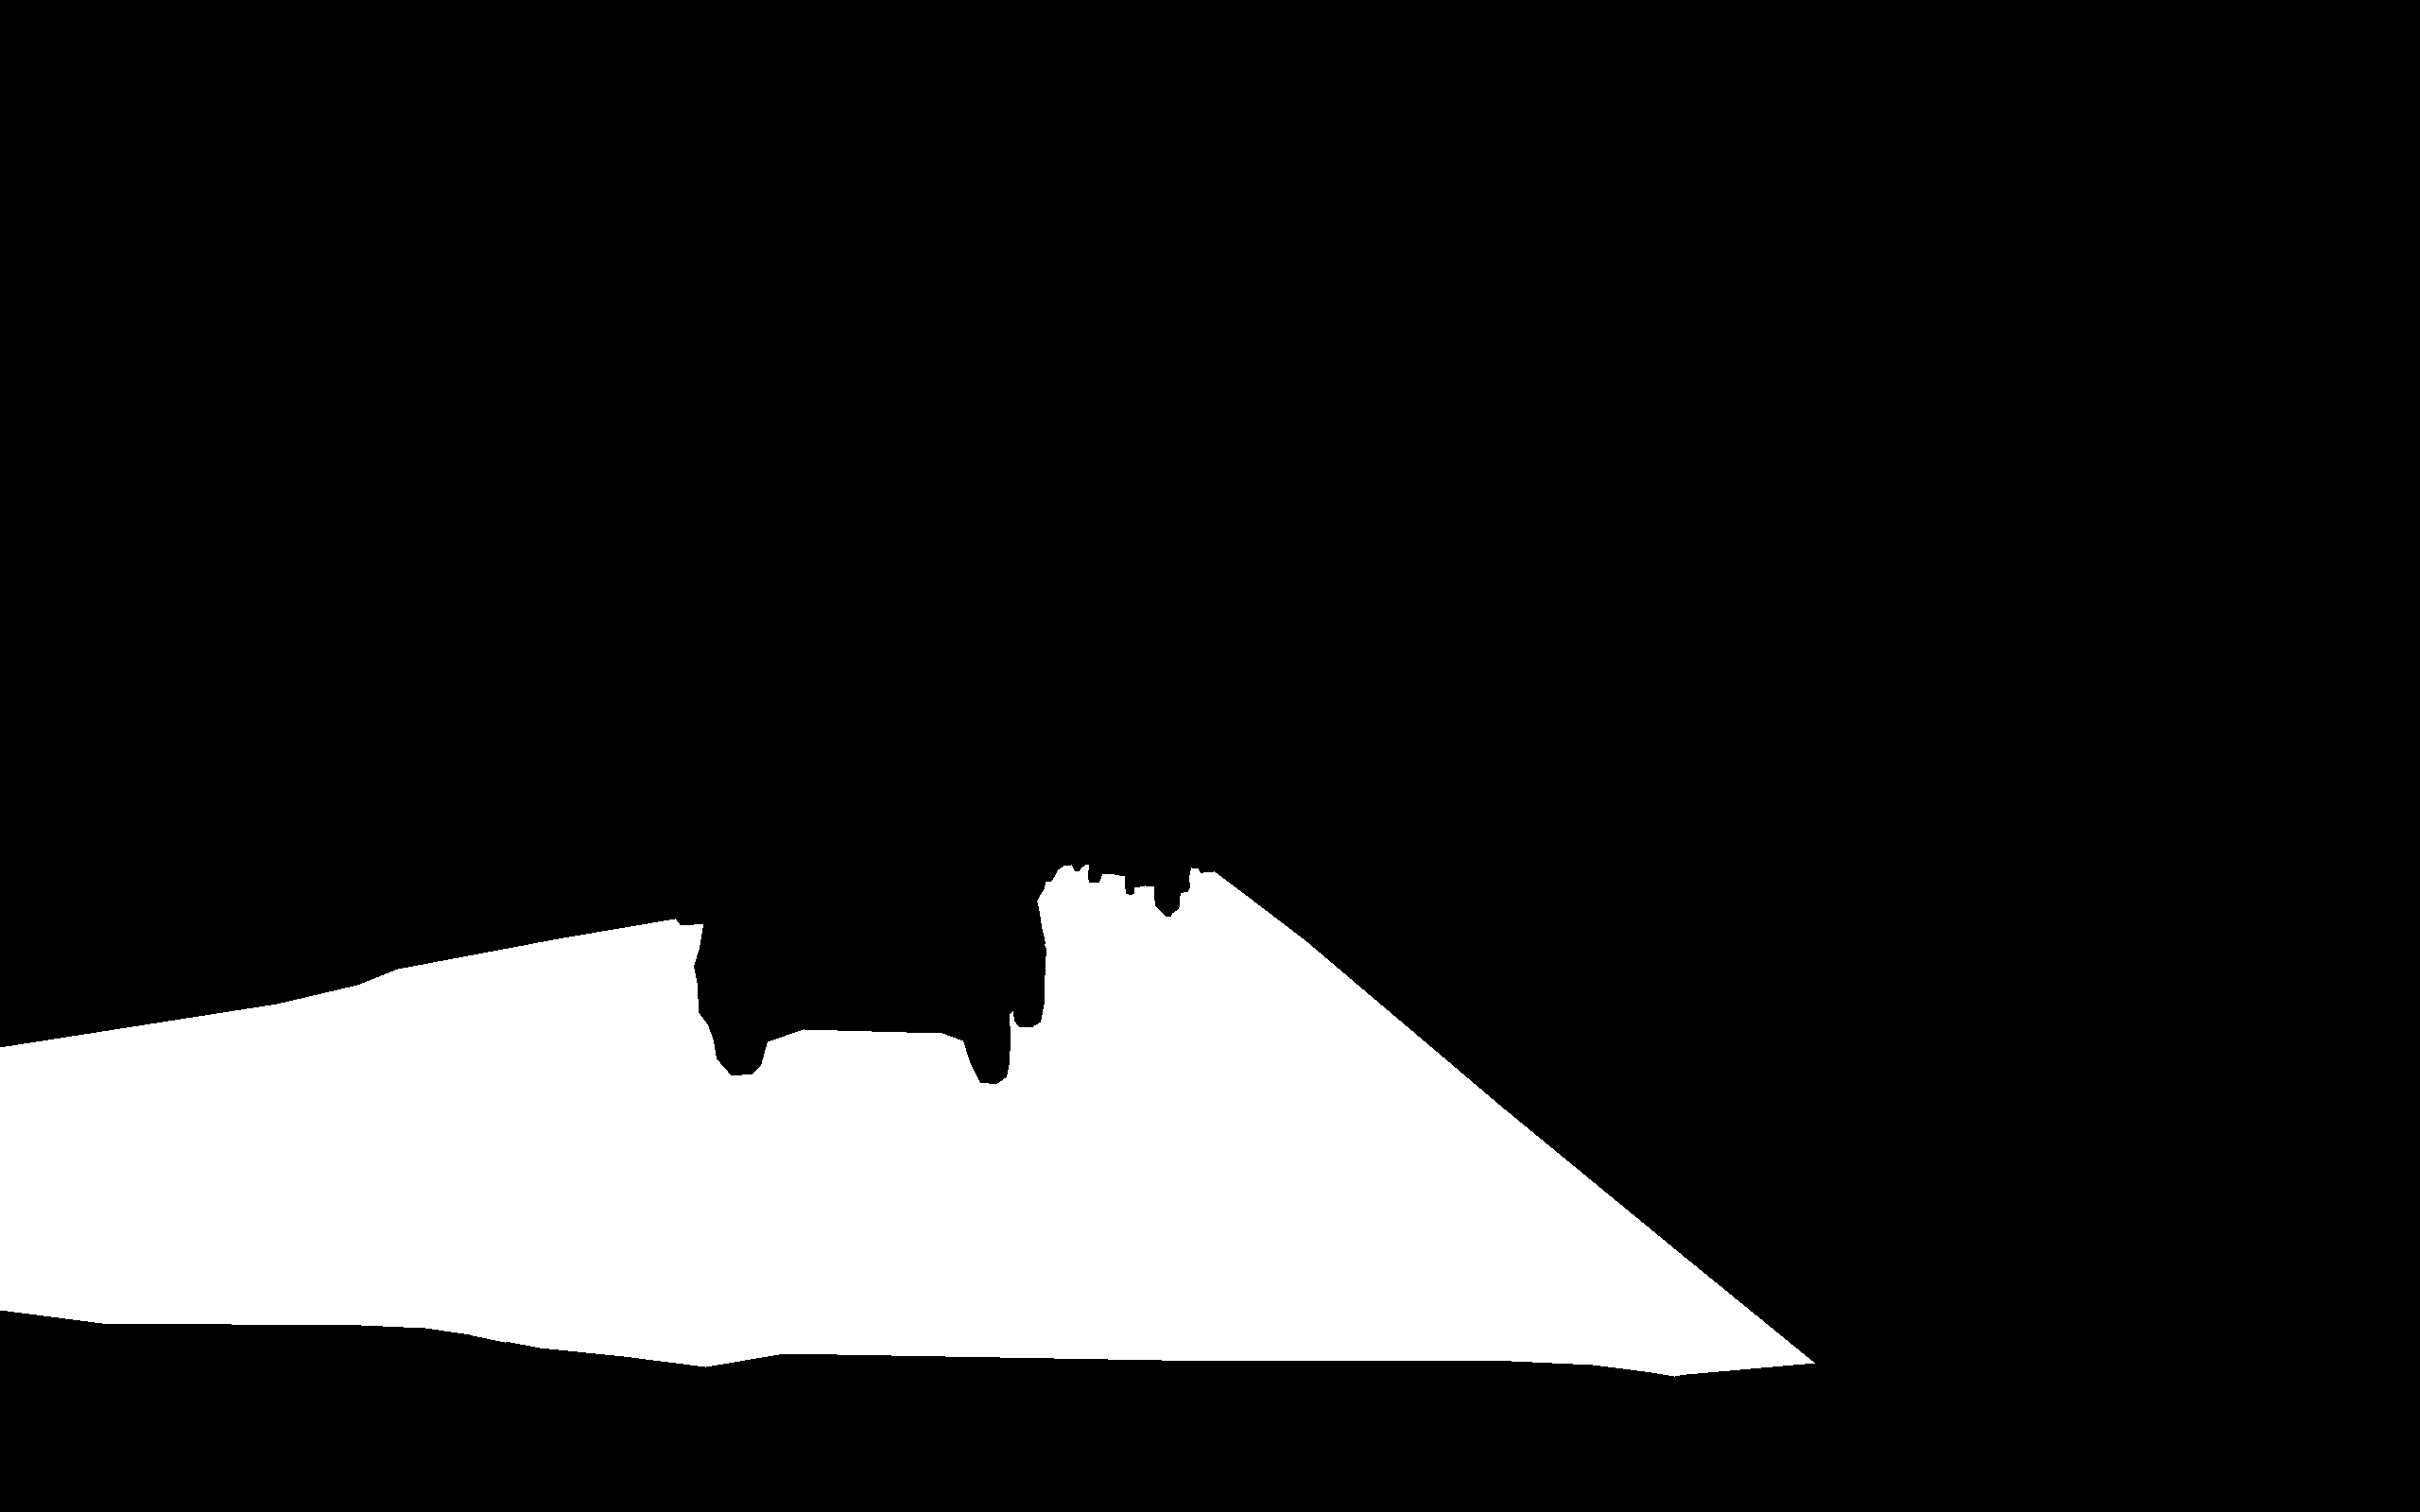

In [16]:
print("Sample from TRAIN masks:")
sample_train = os.listdir("/content/train/masks")[0]
train_path = os.path.join("/content/train/masks", sample_train)
cv2_imshow(cv2.imread(train_path, cv2.IMREAD_GRAYSCALE))

print("\nSample from VALID masks:")
sample_valid = os.listdir("/content/valid/masks")[0]
valid_path = os.path.join("/content/valid/masks", sample_valid)
cv2_imshow(cv2.imread(valid_path, cv2.IMREAD_GRAYSCALE))

In [17]:
class BDDDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = [img for img in os.listdir(images_dir) if img.endswith('.jpg')]
        self.masks = [mask.replace('.jpg', '.png') for mask in self.images]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale

        # Convert mask to binary format with 0 and 1 values
        mask = np.array(mask)
        mask = (mask > 0).astype(np.uint8)  # Assuming non-zero pixels are lanes

        # Convert to PIL Image for consistency in transforms
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            # Assuming to_tensor transform is included which scales pixel values between 0-1
            # mask = to_tensor(mask)  # Convert the mask to [0, 1] range
        mask = TF.functional.resize(img=mask, size=[360, 640], interpolation=Image.NEAREST)
        mask = TF.functional.to_tensor(mask)
        mask = (mask > 0).long()  # Threshold back to binary and convert to LongTensor

        return image, mask

def mean_iou(preds, labels, num_classes):
    # Flatten predictions and labels
    preds_flat = preds.view(-1)
    labels_flat = labels.view(-1)

    # Check that the number of elements in the flattened predictions
    # and labels are equal
    if preds_flat.shape[0] != labels_flat.shape[0]:
        raise ValueError(f"Predictions and labels have mismatched shapes: "
                         f"{preds_flat.shape} vs {labels_flat.shape}")

    # Calculate the Jaccard score for each class
    iou = jaccard_score(labels_flat.cpu().numpy(), preds_flat.cpu().numpy(),
                        average=None, labels=range(num_classes))

    # Return the mean IoU
    return np.mean(iou)

In [18]:
# Define the appropriate transformations
transform = TF.Compose([
    TF.Resize((360, 640)),
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
train_dataset = BDDDataset(images_dir='/content/train/images',
                           masks_dir='/content/train/masks',
                           transform=transform)

valid_dataset = BDDDataset(images_dir='/content/valid/images',
                           masks_dir='/content/valid/masks',
                           transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=6)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=6)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
# Load the pre-trained model
model = SegformerForSemanticSegmentation.from_pretrained('nvidia/segformer-b2-finetuned-ade-512-512')

# Adjust the number of classes for BDD dataset
model.config.num_labels = 2  # Replace with the actual number of classes

In [20]:
# Check for CUDA acceleration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the learning rate scheduler
num_epochs = 30
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# Placeholder for best mean IoU and best model weights
best_iou = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    model.train()
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for batch in train_iterator:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()  # Ensure masks are LongTensors

        # Remove the channel dimension from the masks tensor
        masks = masks.squeeze(1)  # This changes the shape from [batch, 1, H, W] to [batch, H, W]
        optimizer.zero_grad()

        # Pass pixel_values and labels to the model
        outputs = model(pixel_values=images, labels=masks,return_dict=True)

        loss = outputs["loss"]
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)

        train_iterator.set_postfix(loss=loss.item())

    # Evaluation loop for each epoch
    model.eval()
    total_iou = 0
    num_batches = 0
    valid_iterator = tqdm(valid_loader, desc="Validation", unit="batch")
    for batch in valid_iterator:
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device).long()

        with torch.no_grad():
            # Get the logits from the model and apply argmax to get the predictions
            outputs = model(pixel_values=images,return_dict=True)
            outputs = F.interpolate(outputs["logits"], size=masks.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            preds = torch.unsqueeze(preds, dim=1)

        preds = preds.view(-1)
        masks = masks.view(-1)

        # Compute IoU
        iou = mean_iou(preds, masks, model.config.num_labels)
        total_iou += iou
        num_batches += 1
        valid_iterator.set_postfix(mean_iou=iou)

    epoch_iou = total_iou / num_batches
    print(f"Epoch {epoch+1}/{num_epochs} - Mean IoU: {epoch_iou:.4f}")

    # Check for improvement
    if epoch_iou > best_iou:
        print(f"Validation IoU improved from {best_iou:.4f} to {epoch_iou:.4f}")
        best_iou = epoch_iou
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, 'best_model.pth')

# After all epochs, load the best model weights - optional
model.load_state_dict(torch.load('best_model.pth'))
print("Loaded the best model weights!")

Epoch 1/30:   5%|▌         | 4/75 [02:47<48:52, 41.30s/batch, loss=4.14]

In [22]:
from PIL import Image

In [23]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import os

class LaneDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = torch.from_numpy(np.array(mask))

        return image, mask

In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0  # 🔴 disables multiprocessing
)

In [17]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512"
)

model.config.num_labels = 2

model.load_state_dict(
    torch.load("segformer_inference-360640-b2/best_model.pth", map_location=device)
)

model.to(device)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'segformer_inference-360640-b2/best_model.pth'

In [ ]:
image_path = "/content/test_image.jpg"  # <-- your image
frame = cv2.imread(image_path)

In [ ]:
data_transforms = TF.Compose([
    TF.ToPILImage(),
    TF.Resize((360, 640)),
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

In [ ]:
input_tensor = data_transforms(frame).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(pixel_values=input_tensor, return_dict=True)
    logits = outputs["logits"]

    logits = F.interpolate(
        logits, size=(360, 640),
        mode="bilinear", align_corners=False
    )

    preds = torch.argmax(logits, dim=1)   # (1, H, W)

In [ ]:
mask = predskernel = np.ones((3,3), np.uint8)
mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_OPEN, kernel, iterations=2)
mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_CLOSE, kernel, iterations=2)
.squeeze().cpu().numpy()
mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

binary_mask = (mask > 0).astype(np.uint8) * 255

In [ ]:
mask_rgb = np.zeros_like(frame)
mask_rgb[:, :, 1] = binary_mask  # Green channel only

In [ ]:
kernel = np.ones((3,3), np.uint8)
mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_OPEN, kernel, iterations=2)
mask_rgb = cv2.morphologyEx(mask_rgb, cv2.MORPH_CLOSE, kernel, iterations=2)

In [ ]:
blended = cv2.addWeighted(frame, 0.65, mask_rgb, 0.6, 0)

In [ ]:
print("Original Image:")
cv2_imshow(frame)

print("Predicted Lane Mask:")
cv2_imshow(mask_rgb)

print("Overlay Result:")
cv2_imshow(blended)